In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# 汉化字体
matplotlib.rc("font", family='DengXian')
%matplotlib inline


In [33]:

def load_csv():
    data = pd.read_csv("insurance.csv")
    
    # 将'sex'列中的'female'改为0，'male'改为1
    data['sex'] = data['sex'].map({'female': 0, 'male': 1})
    
    # 将'smoker'列中的'yes'改为1，'no'改为0
    data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
    
    # 将'region'列独热编码
    data = pd.get_dummies(data, columns=['region'], prefix='region')
    
    data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] = (data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']] > 0).astype(int)
    
    print(data.head(5))
    return data

# 归一化数据
def custom_normalize_data(data):
    normalized_data = (data - data.min()) / (data.max() - data.min())
    return normalized_data

class Network(object):
    def __init__(self, num_of_weights, lambda_reg=1):
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        self.lambda_reg = lambda_reg  # 正则化参数

    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def loss(self, z, y):
        cost = np.mean((z - y) ** 2)
        return cost

    def loss_with_reg(self, z, y):
        cost = np.mean((z - y) ** 2)
        # 计算 L2 正则化项
        reg = 0.5 * self.lambda_reg * np.sum(self.w ** 2)
        return cost + reg

    def gradient(self, x, y):
        z = self.forward(x)
        error = z - y
        gradient_w = (np.dot(x.T, error) + self.lambda_reg * self.w) / x.shape[0]  # 添加正则化项的梯度
        gradient_b = np.mean(error)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta=0.01):
        self.w -= eta * gradient_w
        self.b -= eta * gradient_b
        
    def train_with_normal_equation(self, x, y):
        # 添加偏置项列
        X_b = np.c_[np.ones((x.shape[0], 1)), x]
        # 使用最小二乘法计算参数估计值
        theta = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T, X_b)), X_b.T), y)
        self.b = theta[0]
        self.w = theta[1:]
        
    def print_model_info(self):
        print("Weights (w):")
        print(self.w)
        print("Bias (b):")
        print(self.b)
        
    def r_squared(self, x, y):
        z = self.forward(x)
        SS_res = np.sum((z - y) ** 2)  # 残差平方和
        SS_tot = np.sum((y - np.mean(y)) ** 2)  # 总平方和
        r2 = 1 - SS_res / SS_tot
        return r2

    def train(self, x, y, iterations=100, eta=0.01, lambda_reg=1):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i + 1) % 1000 == 0:
                print('iter {}, loss {}'.format(i, L))
                r2_test = self.r_squared(x, y)
                print('R方: {}'.format(r2_test))
        print(self.w,self.b)
        return losses, self.w, self.b

data = load_csv()

   age  sex     bmi  children  smoker      charges  region_northeast  \
0   19    0  27.900         0       1  16884.92400                 0   
1   18    1  33.770         1       0   1725.55230                 0   
2   28    1  33.000         3       0   4449.46200                 0   
3   33    1  22.705         0       0  21984.47061                 0   
4   32    1  28.880         0       0   3866.85520                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0  


In [34]:
data = custom_normalize_data(data)
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values.reshape(-1, 1)

In [50]:
offset = int(x.shape[0] * 0.8)
x_train, x_test = x[:offset], x[offset:]
y_train, y_test = y[:offset], y[offset:]

net = Network(x_train.shape[1], lambda_reg=1)
num_iterations = 10000
losses, fw, fb= net.train(x_train, y_train, iterations=num_iterations, eta=0.01)

iter 999, loss 0.22472394163458775
R方: -0.2205711745206569
iter 1999, loss 0.10275358614318394
R方: 0.4417800571369317
iter 2999, loss 0.05527684066139988
R方: 0.6996590903671944
iter 3999, loss 0.03422095051087999
R方: 0.814039375431405
iter 4999, loss 0.02383067860374533
R方: 0.8704883547857594
iter 5999, loss 0.01800360630474719
R方: 0.9021502834717572
iter 6999, loss 0.014287513207472066
R方: 0.9223444259791748
iter 7999, loss 0.011657535399794906
R方: 0.9366376064289643
iter 8999, loss 0.00965954025564489
R方: 0.9474967431004255
iter 9999, loss 0.008074639097678318
R方: 0.9561109883143766
[[ 1.81345792e-01]
 [-7.98733532e-04]
 [ 3.48446420e-01]
 [ 5.27073888e-02]
 [ 3.44593194e-01]
 [-8.66104564e-01]
 [-9.41496804e-01]
 [-9.46119466e-01]
 [-9.78054281e-01]] 0.8276323739713595


Text(0.5, 1.0, '损失率变化图')

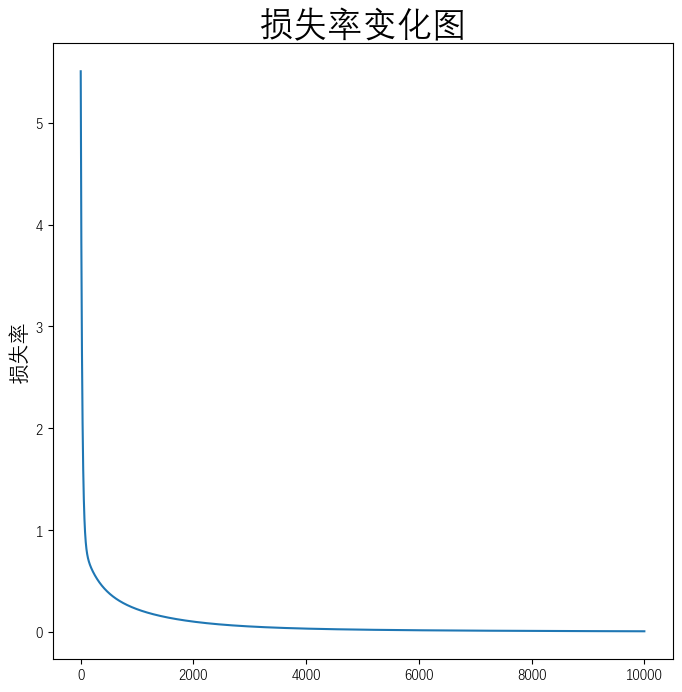

In [51]:
matplotlib.rc("font", family='DengXian')
plt.figure(figsize=(8, 8), num="损失函数")
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.ylabel("损失率", fontsize=15)
plt.title("损失率变化图", fontsize=25)

In [52]:
# 在测试集上验证模型性能
predictions_test = np.dot(x_test, fw) + fb
test_loss = np.mean((predictions_test - y_test) ** 2)

print('测试集损失:', test_loss)

测试集损失: 0.008373309473957332


In [53]:
net.train_with_normal_equation(x_train, y_train)
net.print_model_info()

Weights (w):
[[-3.44212506e-15]
 [ 1.80411242e-16]
 [-1.95329863e-14]
 [-1.07726328e-14]
 [-7.28236915e-15]
 [ 1.88564442e-14]
 [-1.00000000e+00]
 [-1.00000000e+00]
 [-1.00000000e+00]]
Bias (b):
[1.]


In [54]:
net.r_squared(x_test, y_test)

1.0